# Práctica 1 - NNs

### Natalia Martínez García, Lucía Vega Navarrete
### Grupo: AP.11.06

En esta práctica vamos a utilizar el dataset STL-10, que está diseñado para clasificación de imágenes. Vamos a ver que contiene 13,000 imágenes etiquetadas de tamaño 96×96 píxeles en color (RGB), y que estas se clasifican en 10 clases (avión, pájaro, coche, gato, ciervo, perro, caballo, mono, barco, camión). Además incluye 100,000 imágenes sin etiquetar para aprendizaje no supervisado, aunque no las vamos a utilizar. El objetivo es entrenar una red neuronal para clasificar estas imágenes.

Primero cargaremos y preprocesaremos los datos: normalizando las imágenes, convirtiendo las etiquetas a one-hot y aplanando cada imagen en un vector. Después entrenaremos varios modelos cambiando la regularización para intentar mejorar la generalización y evitar sobreajuste.

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models, regularizers, metrics
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [59]:
seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Fijamos una semilla aleatoria para asegurar que los experimentos sean reproducibles y así poder compararlos. Sin ella, procesos como la inicialización de pesos o el shuffle de datos producirían resultados diferentes en cada ejecución, y no podríamos determinar si las diferencias de rendimiento entre modelos se deben a cambios reales en la arquitectura o simplemente al azar.

### 1. Carga del dataset

In [28]:
# Cargamos el dataset STL-10 ya dividido en entrenamiento y test
(train, test), info_ds = tfds.load(
    'stl10',
    split=['train', 'test'],
    as_supervised=True,  # devuelve tuplas (imagen, etiqueta)
    with_info=True # devuelve info extra del dataset (número de clases, tamaño de imagen, etc.)
)

num_clases = info_ds.features['label'].num_classes
nombres_clases = info_ds.features['label'].names
tamano_imagen = info_ds.features['image'].shape
dimension_entrada = np.prod(tamano_imagen)

print("\n" + "="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)

print(f"NOMBRE: {info_ds.name}")
print(f"\nIMÁGENES:")
print(f" - Dimensiones: {tamano_imagen}")
print(f" - Tipo: {info_ds.features['image'].numpy_dtype}")
print(f" - Longitud aplanada: {dimension_entrada}")


print(f"\nETIQUETAS:")
print(f" - Número de clases: {num_clases}")
print(f" - Clases: {', '.join(nombres_clases)}")

print(f"\nSPLITS:")
print(f" - Train: {info_ds.splits['train'].num_examples:,} imágenes")
print(f" - Test: {info_ds.splits['test'].num_examples:,} imágenes")
print(f" - Unlabelled: {info_ds.splits['unlabelled'].num_examples:,} imágenes (NO LOS USAMOS)")


INFORMACIÓN DEL DATASET
NOMBRE: stl10

IMÁGENES:
 - Dimensiones: (96, 96, 3)
 - Tipo: <class 'numpy.uint8'>
 - Longitud aplanada: 27648

ETIQUETAS:
 - Número de clases: 10
 - Clases: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

SPLITS:
 - Train: 5,000 imágenes
 - Test: 8,000 imágenes
 - Unlabelled: 100,000 imágenes (NO LOS USAMOS)


### 2. Preprocesado

In [29]:
def preprocesado(imagen, etiqueta):
    imagen = tf.cast(imagen, tf.float32) / 255.0  # imagen a float32 y escala [0,1]
    imagen = tf.reshape(imagen, [-1]) # aplanamos a un vector unidimensional
    etiqueta = tf.one_hot(etiqueta, depth = num_clases) # one-hot encoding
    return imagen, etiqueta

def preprocesado_dataset(dataset):
    # Creamos listas vacías donde almacenaremos las imágenes y etiquetas preprocesadas.
    imagenes = []
    etiquetas = []

    for img, label in dataset: 
        imagen, etiqueta = preprocesado(img, label) # Aplicamos el preprocesado a cada muestra 
        # Añadimos los resultafos a las listas 
        imagenes.append(imagen)
        etiquetas.append(etiqueta)
    # Convertimos las listas a arrays de numpy
    return np.array(imagenes), np.array(etiquetas)

# Aplicamos la funcion a los conjuntos de entrenamiento y test
train_inputs, train_targets = preprocesado_dataset(train)
test_inputs, test_targets = preprocesado_dataset(test)

Las imágenes vienen en formato uint8 (enteros sin signo), con valores de píxeles  entre 0 y 255, por lo que **escalamos** los píxeles al rango [0, 1] dividiendo por 255 para que la red converja más rápido y de forma más estable.

Además, las imágenes son matrices de 96×96×3 (alto, ancho, canales), pero una red neuronal densa solo puede trabajar con vectores 1D. Por eso necesitamos **aplanar la imagen**: el resultado es un vector de longitud 27648. Con esto la red no conoce que un píxel está al lado del otro (pierde la información espacial).

Usamos **one-hot encoding** cuando tenemos variables categóricas que no tiene sentido ordenar (no hay una categoría “mayor” o “menor” que la otra), como es nuestro caso con las 10 clases del dataset (avión, pájaro, coche, gato, etc.). Con esto convertimos una etiqueta categórica en un vector donde solo la posición correspondiente a esa categoría tiene un 1 y el resto son 0s (por ejemplo, la clase 0 se convierte en [1,0,0,0,0,0,0,0,0,0]). Si dejáramos las etiquetas como números del 0 al 9, podría interpretarse erróneamente que existe una relación de orden entre ellas.


####  División del dataset 

In [30]:
# Permutación aleatoria de índices para mezclar los datos
# Para que la división train/validation sea aleatoria
indices_permutation = np.random.permutation(len(train_inputs))
shuffled_inputs = train_inputs[indices_permutation]
shuffled_targets = train_targets[indices_permutation]

# Calculamos cuántas muestras coger para validación (20% del de entrenamiento)
num_validation_samples = int(0.2 * len(train_inputs))

# Separamos el primer 20% para validación
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
# El resto se mantiene para entrenamiento
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

Dividimos el conjunto de entrenamiento original en dos partes: entrenamiento (80%) y validación (20%), lo que queda en 4000 imágenes para entrenamiento y 1000 para validación. El conjunto de entrenamiento se usa para que el modelo aprenda ajustando sus pesos, mientras que el de validación sirve para evaluar su rendimiento durante el entrenamiento sin que el modelo vea esos datos en el proceso de aprendizaje. Lo vamos a usar para detectar sobreajuste (si la accuracy en entrenamiento sube pero en validación baja, el modelo está memorizando en lugar de generalizar).

Para la división del dataset, se mezclan las muestras del conjunto de entrenamiento, de manera que la separación entre entrenamiento y validación sea aleatoria. La división que hemos escogido permite evaluar correctamente el modelo sin reducir demasiado la cantidad de datos disponibles para entrenar.

El conjunto de test, por su parte, permanece completamente separado y solo se usa al final para evaluar el rendimiento real del modelo en datos nunca vistos.

### 3. Creación y entrenamiento de modelos

In [31]:
def entrenar(modelo, train, val, test, epochs=15, use_early_stopping=False, 
             es_monitor='val_loss', es_patience=3, es_mode='min'):
    train_x, train_y = train
    val_x, val_y = val
    test_x, test_y = test
    
    callbacks = None
    if use_early_stopping:
        callbacks = [EarlyStopping(
            monitor=es_monitor,
            patience=es_patience,
            mode=es_mode,
            restore_best_weights=True,
            verbose=1
        )]
    
    history = modelo.fit(
        train_x, train_y,
        validation_data=(val_x, val_y),
        epochs=epochs,
        callbacks=callbacks
    )
    
    loss, acc, prec, rec, f1 = modelo.evaluate(test_x, test_y, verbose=0)
    
    print("\nResultados en TEST:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    return history, loss, acc, prec, rec, f1

Hemos decidido utilizar (por defecto) 15 epochs en el entrenamiento (un epoch es una pasada completa por todos los datos de entrenamiento). Si el número de epochs es muy bajo (como 3-5) el modelo no aprende bien; si es muy alto (como 50+) puede haber mucho sobreajuste y además pérdida de tiempo. Con 15 epochs podemos evaluar el comportamiento del modelo y ajustar después si es necesario, considerando que tenemos un conjunto de entrenamiento pequeño.

Después del entrenamiento completo, evaluamos el rendimiento de ese modelo con el conjunto de test, usando las siguientes métricas:
- **Loss**: mide qué tan equivocadas son las predicciones del modelo.
- **Accuracy**: nos da el porcentaje total de aciertos, aunque es insuficiente por sí sola ya que puede ser engañosa en caso de que las clases estén desbalanceadas, por lo que vamos a utilizar las siguientes para complementarla.
- **Precision**: mide cuántas de las predicciones positivas del modelo son realmente correctas, evitando falsos positivos (de todas las veces que el modelo dijo "esto es un gato", ¿cuántas veces acertó?).
- **Recall**: evalúa falsos negativos (cuando no detecta algo que sí es)(de todos los gatos reales en el dataset, ¿cuántos detectó correctamente?).
- **F1-score**: combina precision y recall en una sola métrica y siempre es balanceado.

<p style="color:red; font-weight:bold; line-height:1.5;">
PARA LOS MODELOS: <br>
- Explicar cada cosa del compile<br>
- El num de neuronas en las capas ocultas y la activación <br>
- El dropout <br>
- regularizaciones
</p>

In [32]:
# Función cogida del Lab5 (Optimización) para enseñar como van cambiando trainig y test y ver el overfitting

def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    # Crear figura con 2 subplots lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfica de accuracy
    ax1.plot(epochs, accuracy, "b-o", label="Training accuracy")
    ax1.plot(epochs, val_accuracy, "r--o", label="Validation accuracy")
    ax1.set_title("Training and validation accuracy")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica de loss
    ax2.plot(epochs, loss, "b-o", label="Training loss")
    ax2.plot(epochs, val_loss, "r--o", label="Validation loss")
    ax2.set_title("Training and validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#### 3.1. Modelo 1 - Vanilla (sin regularización)

In [33]:
# Creamos un modelo secuencial, las capas se apilan una tras otra
modelo_base = models.Sequential([
    layers.Input(shape=(dimension_entrada,)), # Capa de entrada con el tamaño del vector aplanado
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'), # Primera capa oculta con 512 neuronas y activación ReLU
    layers.Dense(64, activation='relu'), # Segunda capa oculta con 256 neuronas y activación ReLU
    layers.Dense(num_clases, activation='softmax') # Capa de salida con tantas neuronas como clases (10) y activación softmax
])

modelo_base.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), # Optimizador Adam
    loss='categorical_crossentropy', # Funcion de loss
    metrics=[ # Las que va a devolver el entrenamiento
        'accuracy', # porcentaje total de aciertos
        metrics.Precision(name='precision'),# mide falsos positivos
        metrics.Recall(name='recall'),  # mide falsos negativos
        metrics.F1Score(name='f1_score', average='macro')  # media F1 por clase
    ]
)

modelo_base.summary() # Mostramos un resumen con el número de capas, parámetros y formas de entrada/salida

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Empezamos con una red de neuronas **vanilla**, tras varias pruebas nos hemos quedado con esta:
- **Capa de entrada**: Recibe como un vector de 27,648 valores, que es la imagen que aplanamos en el preprocesado.
- **Tres capas ocultas**: de 256, 128 y 64 neuronas, ambas con función de activación ReLU (si el valor de salida de la neurona es positivo, lo deja pasar tal cual y si es negativo lo convierte en 0). Esta permite que la red aprenda patrones complejos pero es simple y rápida de calcular. Cada capa oculta es completamente conectada
- **Capa de salida**: 10 neuronas (una por clase) con función de activación softmax que convierte las salidas en probabilidades que sumen 1. La neurona con mayor probabilidad indica la clase predicha.

La red va reduciendo el número de neuronas de forma progresiva para que cada capa aprenda representaciones cada vez más abstractas y las últimas ya toman la decisión final de clasificación.

Usamos el optimizador **Adam** con un learning rate de 0.001 para ajustar los pesos automáticamente durante el entrenamiento. Este converge rápido y se utiliza mucho actualmente. Como función de **loss** para penalizar predicciones incorrectas, utilizamos Categorical Crossentropy al tratarse de una clasificación multiclase que además hemos puesto en forma one-hot.

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2205 - f1_score: 0.2157 - loss: 2.2719 - precision: 0.3926 - recall: 0.0475 - val_accuracy: 0.2500 - val_f1_score: 0.2128 - val_loss: 2.0460 - val_precision: 0.5317 - val_recall: 0.0670
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3018 - f1_score: 0.2923 - loss: 1.9398 - precision: 0.5379 - recall: 0.0780 - val_accuracy: 0.2710 - val_f1_score: 0.2321 - val_loss: 1.9857 - val_precision: 0.4739 - val_recall: 0.1000
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3120 - f1_score: 0.3025 - loss: 1.8661 - precision: 0.5869 - recall: 0.1030 - val_accuracy: 0.2660 - val_f1_score: 0.2318 - val_loss: 1.9654 - val_precision: 0.4562 - val_recall: 0.0990
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3465 - f1_score: 0.3398 - loss: 1.8032 - precision: 0.6269 - recall: 0.1315 - val_accuracy: 0.2900 - val_f1_score: 0.2795 - val_loss: 1.9189 - val_precision: 0.4530 - val_rec

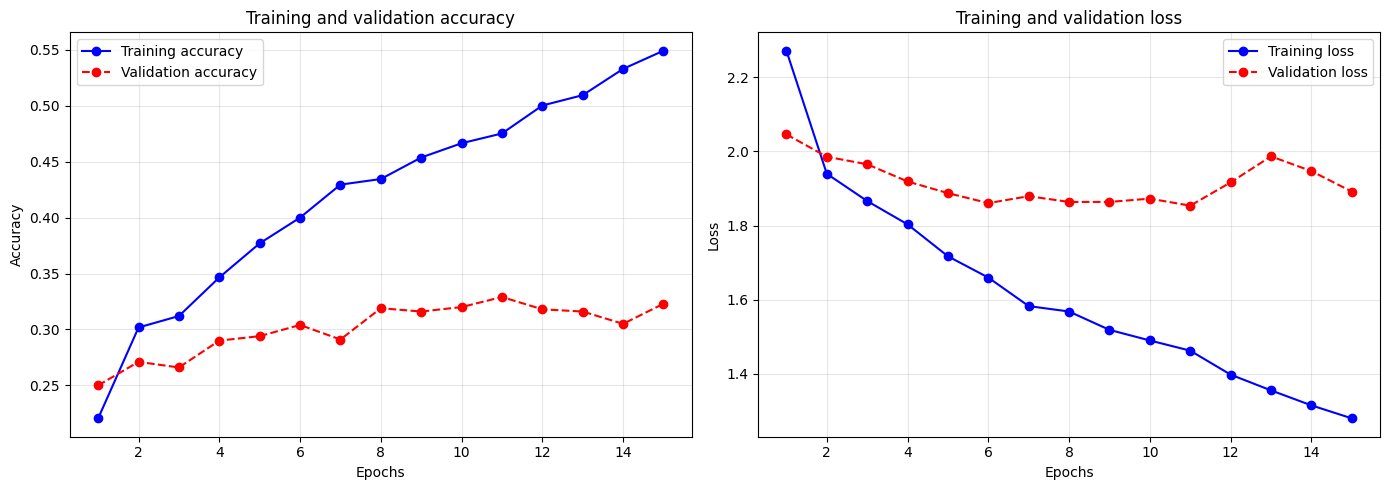

In [34]:
hist_vanilla, loss_vanilla, acc_vanilla, prec_vanilla, rec_vanilla, f1_vanilla = entrenar(
    modelo_base,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_vanilla)

CAMBIAR LOS NUMEROS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Durante el entrenamiento vemos que hay un claro **sobreajuste**. Las métricas de entrenamiento mejoran constantemente: la accuracy sube de 20.02% a 50.88% y el loss disminuye de 4.45 a 1.34 a lo largo de los 15 epochs. Sin embargo, las métricas de validación se estancan alrededor del 25-30% de accuracy y el loss de validación sube hasta a 2.19. Esta separación indica que el modelo está memorizando los datos de entrenamiento en lugar de aprender patrones que generalicen bien a datos nuevos. Necesitamos aplicar regularización para evitar este sobreajuste.

Los resultados en test confirman este bajo rendimiento: 
- El accuracy de 31.06% indica que el modelo acierta solo 1 de cada 3 imágenes (aunque en un problema de 10 clases, predecir completamente al azar daría un 10% de aciertos, por lo que el modelo sí ha aprendido algo).
- El recall de 19.86% es el más problemático. Significa que de todos los aviones reales en el dataset, solo detecta correctamente unos 2 de cada 10; lo mismo ocurre para gatos, perros y el resto de clases. El modelo es muy conservador y prefiere no clasificar muchos casos antes que arriesgarse a equivocarse.
- La precision de 45.22% nos dice que cuando el modelo predice algo acierta aproximadamente la mitad de las veces.
- La combinación de baja precision y bajo recall resulta en un F1-score de 0.28, confirmando que el modelo tiene un rendimiento malo.
- El loss de 2 en test está muy por encima del loss de entrenamiento (1.34), otra evidencia clara del sobreajuste (un modelo que generaliza bien debería tener losses similares en entrenamiento y test).

#### 3.2. Modelo 2 - Dropout

**Notitas**
- con dropout 0.5: El rendimiento es una shit. Precisión y recall son casi nulos, indicando que el dropout fue demasiado alto (0.5) o aplicado en capas pequeñas

In [42]:
modelo_dropout = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

modelo_dropout.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
loss='categorical_crossentropy',
metrics=[
    'accuracy', # porcentaje total de aciertos
    metrics.Precision(name='precision'),# mide falsos positivos
    metrics.Recall(name='recall'),  # mide falsos negativos
    metrics.F1Score(name='f1_score', average='macro')  # media F1 por clase
])

modelo_dropout.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1663 - f1_score: 0.1622 - loss: 2.2822 - precision: 0.2172 - recall: 0.0132 - val_accuracy: 0.2340 - val_f1_score: 0.1795 - val_loss: 2.0011 - val_precision: 0.5625 - val_recall: 0.0180
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2528 - f1_score: 0.2438 - loss: 2.0046 - precision: 0.5409 - recall: 0.0380 - val_accuracy: 0.2370 - val_f1_score: 0.1847 - val_loss: 1.9511 - val_precision: 0.4639 - val_recall: 0.0450
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2790 - f1_score: 0.2703 - loss: 1.9339 - precision: 0.5857 - recall: 0.0658 - val_accuracy: 0.2550 - val_f1_score: 0.2172 - val_loss: 1.9285 - val_precision: 0.4961 - val_recall: 0.0630
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2925 - f1_score: 0.2821 - loss: 1.9010 - precision: 0.5996 - recall: 0.0752 - val_accuracy: 0.2660 - val_f1_score: 0.2308 - val_loss: 1.8827 - val_precision: 0.5448 - val_rec

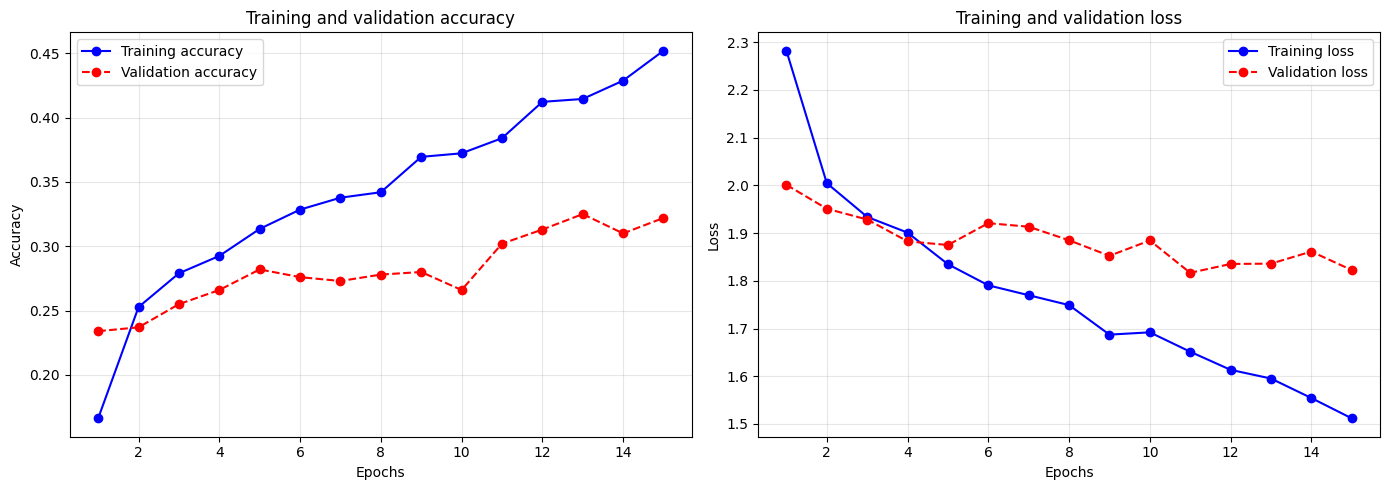

In [43]:
hist_dropout, loss_dropout, acc_dropout, prec_dropout, rec_dropout, f1_dropout = entrenar(
    modelo_dropout,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_dropout)

### 3.3. Modelo Early Stopping

In [45]:
modelo_early_stopping = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

modelo_early_stopping.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ])
    
modelo_early_stopping.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2205 - f1_score: 0.2157 - loss: 2.2719 - precision: 0.3926 - recall: 0.0475 - val_accuracy: 0.2500 - val_f1_score: 0.2128 - val_loss: 2.0460 - val_precision: 0.5317 - val_recall: 0.0670
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3018 - f1_score: 0.2923 - loss: 1.9398 - precision: 0.5379 - recall: 0.0780 - val_accuracy: 0.2710 - val_f1_score: 0.2321 - val_loss: 1.9857 - val_precision: 0.4739 - val_recall: 0.1000
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3120 - f1_score: 0.3025 - loss: 1.8661 - precision: 0.5869 - recall: 0.1030 - val_accuracy: 0.2660 - val_f1_score: 0.2318 - val_loss: 1.9654 - val_precision: 0.4562 - val_recall: 0.0990
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3465 - f1_score: 0.3398 - loss: 1.8032 - precision: 0.6269 - recall: 0.1315 - val_accuracy: 0.2900 - val_f1_score: 0.2795 - val_loss: 1.9189 - val_precision: 0.4530 - val_rec

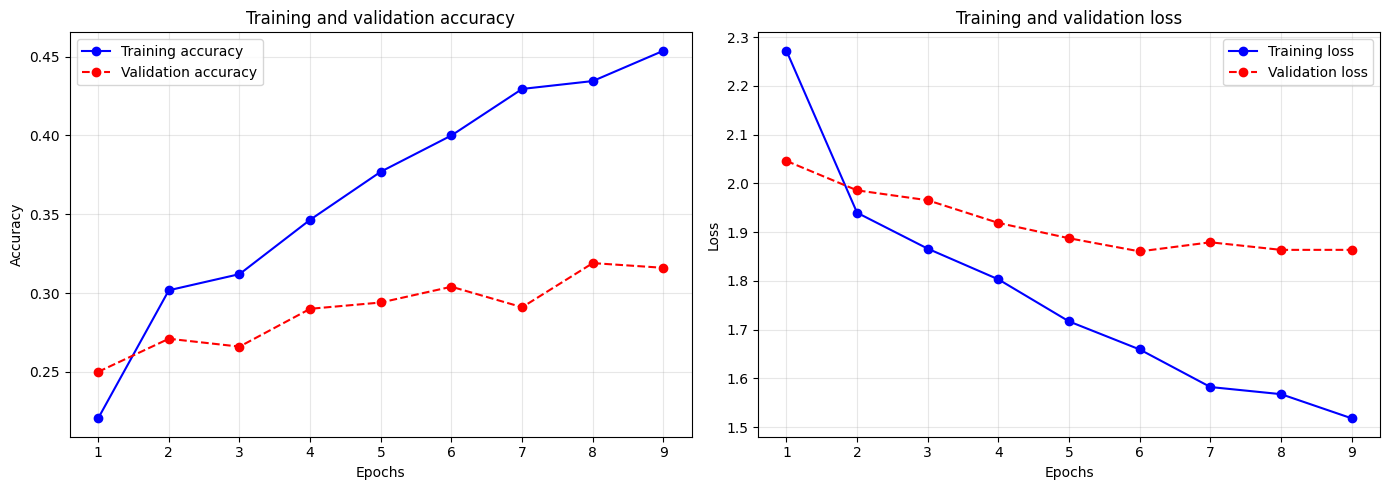

In [46]:
hist_early_stopping, loss_early_stopping, acc_early_stopping, prec_early_stopping, rec_early_stopping, f1_early_stoppingt = entrenar(
    modelo_early_stopping,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets),
    epochs=30,
    use_early_stopping=True,
    es_patience=3
)

plot(hist_early_stopping)

#### 3.3. Modelo 3 - Regularización L1

In [48]:

modelo_L1 = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(5e-5)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(5e-6)),
    layers.Dense(num_clases, activation='softmax')
])
modelo_L1.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', # porcentaje total de aciertos
        metrics.Precision(name='precision'),# mide falsos positivos
        metrics.Recall(name='recall'),  # mide falsos negativos
        metrics.F1Score(name='f1_score', average='macro')  # media F1 por clase
    ])

modelo_L1.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2298 - f1_score: 0.2248 - loss: 4.3345 - precision: 0.4032 - recall: 0.0443 - val_accuracy: 0.2190 - val_f1_score: 0.1708 - val_loss: 3.7721 - val_precision: 0.4264 - val_recall: 0.0550
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2865 - f1_score: 0.2798 - loss: 3.4359 - precision: 0.5620 - recall: 0.0725 - val_accuracy: 0.2530 - val_f1_score: 0.2131 - val_loss: 3.2409 - val_precision: 0.4663 - val_recall: 0.0830
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3212 - f1_score: 0.3122 - loss: 2.9714 - precision: 0.5967 - recall: 0.0988 - val_accuracy: 0.2560 - val_f1_score: 0.2030 - val_loss: 3.0264 - val_precision: 0.3947 - val_recall: 0.0900
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3285 - f1_score: 0.3202 - loss: 2.7116 - precision: 0.6048 - recall: 0.1205 - val_accuracy: 0.2680 - val_f1_score: 0.2335 - val_loss: 2.7246 - val_precision: 0.4356 - val_rec

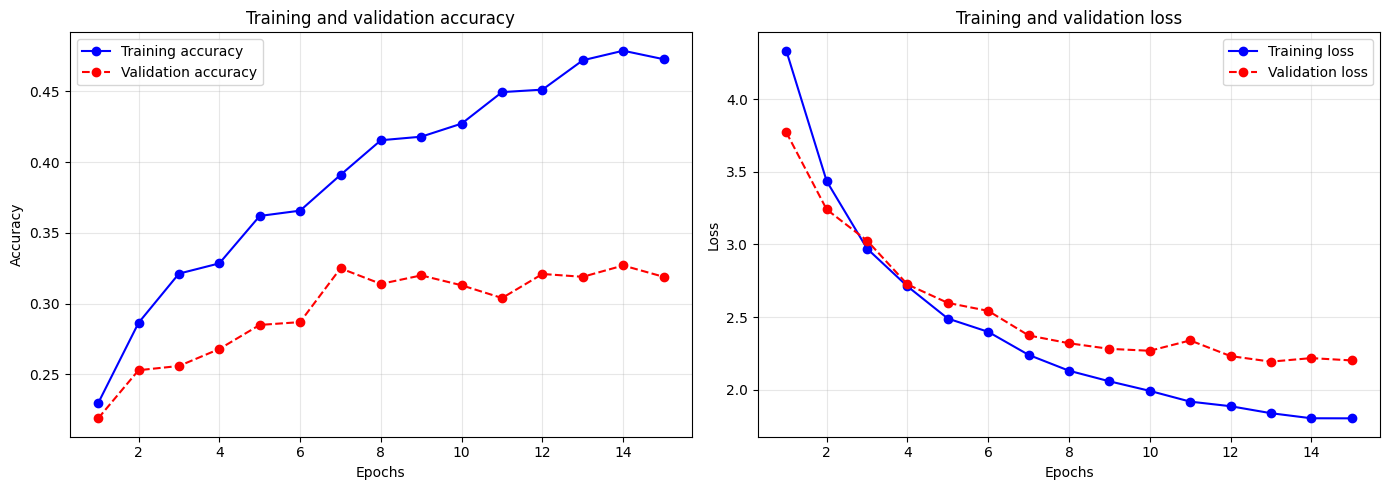

In [49]:
hist_L1, loss_L1, acc_L1, prec_L1, rec_L1, f1_L1 = entrenar(
    modelo_L1,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_L1)

#### 3.4. Modelo 4 - Regularización L2

In [54]:
modelo_L2 = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(num_clases, activation='softmax')
])

modelo_L2.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', # porcentaje total de aciertos
        metrics.Precision(name='precision'),# mide falsos positivos
        metrics.Recall(name='recall'),  # mide falsos negativos
        metrics.F1Score(name='f1_score', average='macro')  # media F1 por clase
        ])

modelo_L2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.2303 - f1_score: 0.2216 - loss: 7.2487 - precision: 0.4190 - recall: 0.0530 - val_accuracy: 0.2630 - val_f1_score: 0.2298 - val_loss: 5.3437 - val_precision: 0.5784 - val_recall: 0.0590
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2982 - f1_score: 0.2856 - loss: 4.5258 - precision: 0.5880 - recall: 0.0785 - val_accuracy: 0.2710 - val_f1_score: 0.2061 - val_loss: 3.9614 - val_precision: 0.4833 - val_recall: 0.1010
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3270 - f1_score: 0.3142 - loss: 3.5146 - precision: 0.6447 - recall: 0.0953 - val_accuracy: 0.2870 - val_f1_score: 0.2521 - val_loss: 3.2806 - val_precision: 0.5455 - val_recall: 0.1080
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3473 - f1_score: 0.3349 - loss: 3.0272 - precision: 0.6266 - recall: 0.0978 - val_accuracy: 0.2900 - val_f1_score: 0.2582 - val_loss: 2.9540 - val_precision: 0.5521 - val_rec

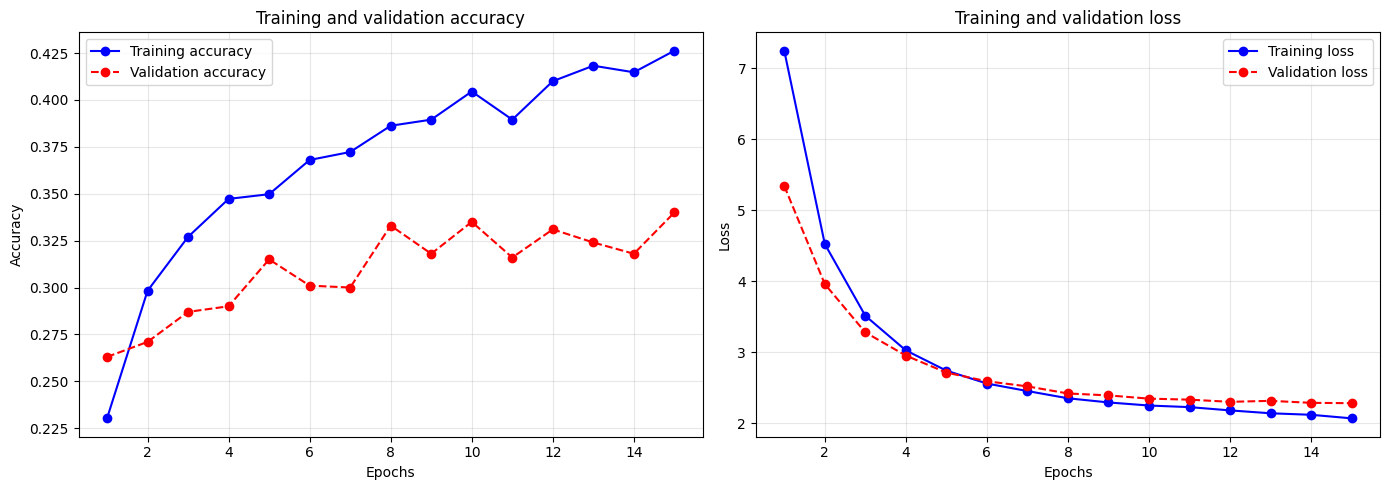

In [55]:
hist_L2, loss_L2, acc_L2, prec_L2, rec_L2, f1_L2 = entrenar(
    modelo_L2,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_L2)

In [57]:
# !!!!!!!!!!!!!!!

modelo_hibrido = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(2e-5)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),

    layers.Dense(num_clases, activation='softmax')
])

modelo_hibrido.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),  # más estable
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro')
    ]
)

modelo_hibrido.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1912 - f1_score: 0.1872 - loss: 3.1315 - precision: 0.3207 - recall: 0.0233 - val_accuracy: 0.2170 - val_f1_score: 0.1485 - val_loss: 2.8273 - val_precision: 0.4043 - val_recall: 0.0190
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2385 - f1_score: 0.2326 - loss: 2.6893 - precision: 0.4684 - recall: 0.0315 - val_accuracy: 0.2350 - val_f1_score: 0.2127 - val_loss: 2.5357 - val_precision: 0.5042 - val_recall: 0.0600
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2747 - f1_score: 0.2656 - loss: 2.4713 - precision: 0.5711 - recall: 0.0602 - val_accuracy: 0.2480 - val_f1_score: 0.1961 - val_loss: 2.4310 - val_precision: 0.5087 - val_recall: 0.0880
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3060 - f1_score: 0.2995 - loss: 2.3079 - precision: 0.6152 - recall: 0.0808 - val_accuracy: 0.2800 - val_f1_score: 0.2602 - val_loss: 2.2617 - val_precision: 0.5263 - val_rec

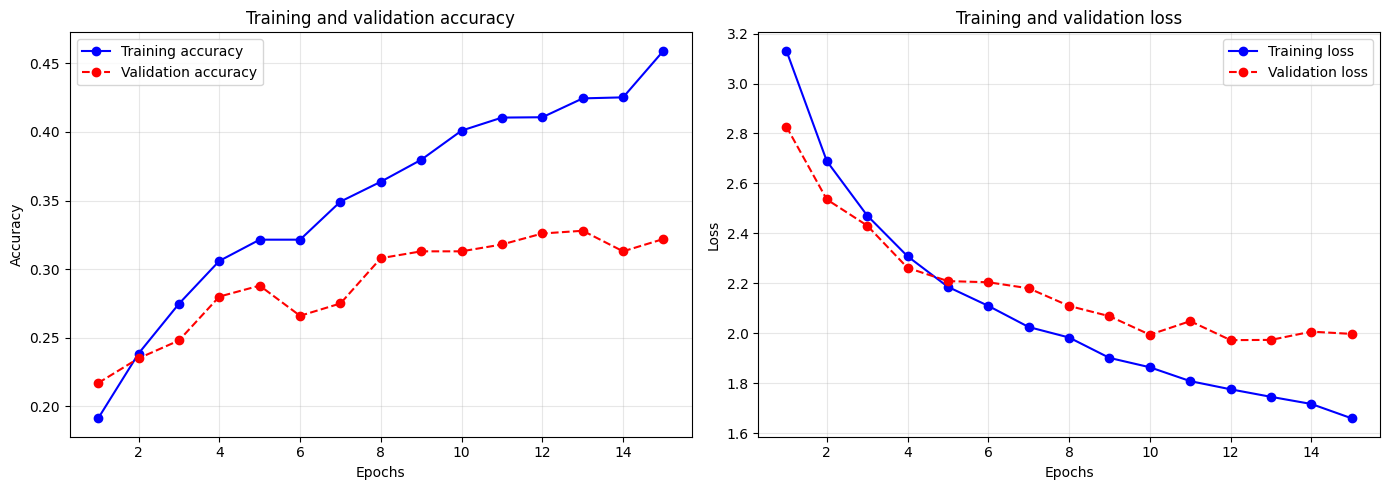

In [58]:
hist_hibrido, loss_hibrido, acc_hibrido, prec_hibrido, rec_hibrido, f1_hibrido = entrenar(
    modelo_hibrido,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets))

plot(hist_hibrido)

In [60]:
modelo_hibrido_v1 = models.Sequential([
    layers.Input(shape=(dimension_entrada,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(2e-5)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),
    layers.Dropout(0.15),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_clases, activation='softmax')
])

modelo_hibrido_v1.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             metrics.Precision(name='precision'),
             metrics.Recall(name='recall'),
             metrics.F1Score(name='f1_score', average='macro')]
)

modelo_hibrido_v1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,946 (27.16 MB)

 Trainable params: 7,119,946 (27.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.1912 - f1_score: 0.1872 - loss: 3.1315 - precision: 0.3207 - recall: 0.0233 - val_accuracy: 0.2170 - val_f1_score: 0.1485 - val_loss: 2.8273 - val_precision: 0.4043 - val_recall: 0.0190
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2385 - f1_score: 0.2326 - loss: 2.6893 - precision: 0.4684 - recall: 0.0315 - val_accuracy: 0.2350 - val_f1_score: 0.2127 - val_loss: 2.5357 - val_precision: 0.5042 - val_recall: 0.0600
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2747 - f1_score: 0.2656 - loss: 2.4713 - precision: 0.5711 - recall: 0.0602 - val_accuracy: 0.2480 - val_f1_score: 0.1961 - val_loss: 2.4310 - val_precision: 0.5087 - val_recall: 0.0880
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3060 - f1_score: 0.2995 - loss: 2.3079 - precision: 0.6152 - recall: 0.0808 - val_accuracy: 0.2800 - val_f1_score: 0.2602 - val_loss: 2.2617 - val_precision: 0.5263 - val_rec

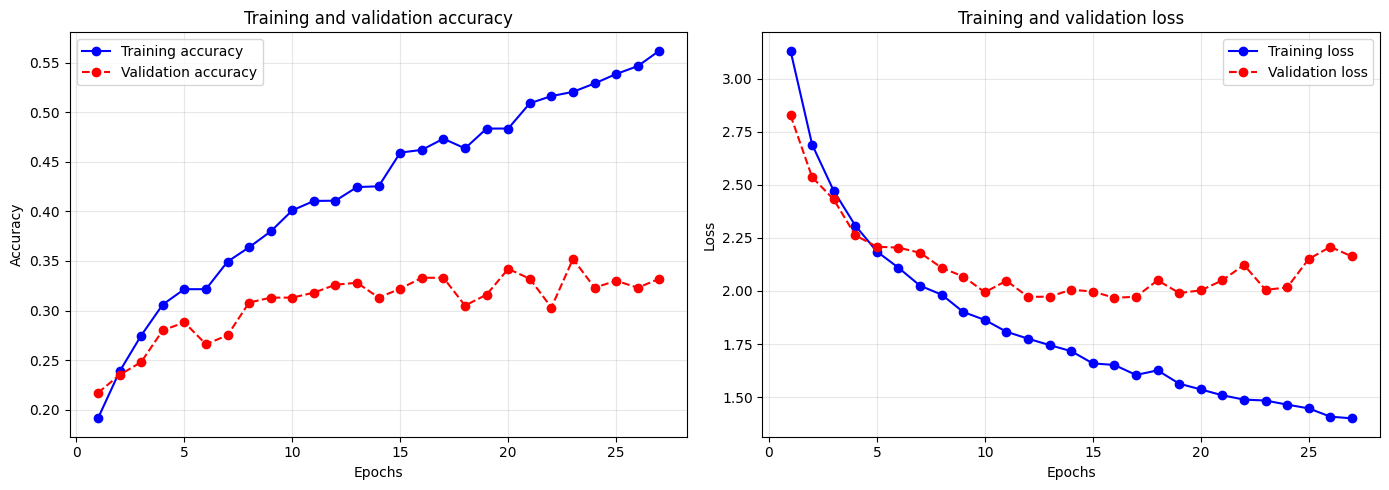

In [61]:

hist_v1, loss_v1, acc_v1, prec_v1, rec_v1, f1_v1 = entrenar(
    modelo_hibrido_v1,
    (training_inputs, training_targets),
    (val_inputs, val_targets),
    (test_inputs, test_targets),
    epochs=30,  # Más épocas
    use_early_stopping=True,
    es_monitor='val_accuracy',
    es_patience=4,
    es_mode='max'
)

plot(hist_v1)

# <span style="color:red">nota: las graficas podemos ponerlas en otros cuadrados para que no queden escondidas en el scroll pero no lo voy a hacer ahora que no lo quiero volver a ejecutar todo se me caen los ojos </span>

### 4. Comparación y resumen de resultados

In [ ]:
import pandas as pd

# Creamos la tabla con los resultados obtenidos
# (sustituye los valores entre corchetes por tus variables reales si cambian los nombres)

results = pd.DataFrame({
    "Modelo": ["Vanilla","Dropout","L1","L2 ","BatchNorm"],
    "Regularización": ["Ninguna","Dropout(x)","L1(x)","L2(x)","Batch Normalization"],    # pongo (x) para poner luego los parámetros buenos
    "Accuracy": [acc_vanilla * 100,acc_dropout * 100,acc_L1 * 100,acc_L2 * 100,acc_bn * 100],
    "Precision": [prec_vanilla,prec_dropout,prec_L1,rec_L2,prec_bn],
    "Recall": [rec_vanilla,rec_dropout,rec_L1,rec_L2,rec_bn],
    "F1-Score": [f1_vanilla,f1_dropout,f1_L1,f1_L2,f1_bn]
})

results = results.round({"Accuracy": 3,"Precision": 3,"Recall": 3,"F1-Score": 3})

# Mostramos la tabla ordenada por Accuracy descendente
results.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

### 6. Conclusión

La red neuronal base aprende rápido y obtiene una precisión aceptable en entrenamiento, pero empieza a sobreajustar. Esto se ve porque la accuracy de entrenamiento sigue subiendo mientras que la accuracy de validación deja de mejorar e incluso baja ligeramente. Eso significa que el modelo se está adaptando demasiado a las imágenes concretas del set de entrenamiento y no generaliza tan bien a imágenes nuevas.

Cuando añadimos regularización (L2 y Dropout) el entrenamiento es más lento y la accuracy de entrenamiento es un poco más baja, pero la accuracy de validación es más estable y en general más cercana a la de entrenamiento. Esto indica que el modelo es menos dependiente de detalles concretos del conjunto de entrenamiento. En el conjunto de test, que es el que no usamos nunca para ajustar nada, el modelo regularizado mejora ligeramente el resultado respecto al modelo base. Esto sugiere que la regularización ayuda a la red a generalizar mejor.

Como desventaja, el modelo regularizado tarda un poco más en converger y necesita más épocas para exprimir su potencial, porque al apagar neuronas (Dropout) y penalizar pesos grandes (L2) le cuesta un poco más “memorizar” patrones. Aun así, para este problema de clasificación de imágenes, es preferible un modelo que generaliza mejor aunque entrene un poco más lento.